In [14]:
!unzip my_dataset_2.zip

Archive:  my_dataset_2.zip
replace my_dataset_2/train2014/COCO_train2014_000000066642.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace my_dataset_2/train2014/COCO_train2014_000000324332.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [15]:
# =========================================
# 1. Imports
# =========================================
import os, json
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.models as models
from transformers import DistilBertTokenizer, DistilBertModel
import torch.optim as optim

# =========================================
# 2. Dataset
# =========================================
class RefDataset(Dataset):
    def __init__(self, img_dir, instances_path, ref_path, transform=None):
        self.img_dir = img_dir
        self.transform = transform

        # Load COCO instances
        with open(instances_path, "r") as f:
            self.instances = json.load(f)
        # Map image_id -> file_name
        self.id2file = {img['id']: img['file_name'] for img in self.instances['images']}
        # Map annotation_id -> bbox
        self.ann_dict = {ann['id']: ann for ann in self.instances['annotations']}

        # Load RefCOCOG expressions
        with open(ref_path, "r") as f:
            self.refs = json.load(f)

        # Build dataset: each item = (image_path, caption, bbox)
        self.data = []
        # Fixed version for list-structured JSON
        for ref in self.refs:
          img_file = self.id2file[ref['image_id']]
          ann = self.ann_dict[ref['ann_id']]
          bbox = ann['bbox']  # [x, y, w, h]
          bbox = [bbox[0], bbox[1], bbox[0]+bbox[2], bbox[1]+bbox[3]]
          # Get the first raw sentence from sentences list
          caption = ref.get('sentences', [])
          if len(caption) > 0:
              caption = caption[0]['raw']
          else:
             caption = "undefined"
          # Take the first sentence's raw text
          sentences = ref.get('sentences', [])
          if len(sentences) > 0:
              caption = sentences[0]['raw']
          else:
              caption = "undefined"

          self.data.append({
            'image_path': os.path.join(self.img_dir, img_file),
            'caption': caption,
            'bbox': bbox
        })

        # Tokenizer
        self.tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        img = Image.open(item['image_path']).convert("RGB")
        if self.transform:
            img = self.transform(img)

        # Get image width and height
        if isinstance(img, Image.Image):
            w, h = img.size
        else:  # torch tensor
            _, h, w = img.shape

        # Normalize bbox
        bbox = torch.tensor([
            item['bbox'][0]/w,
            item['bbox'][1]/h,
            item['bbox'][2]/w,
            item['bbox'][3]/h
        ], dtype=torch.float)

        caption = item['caption']
        tokens = self.tokenizer(caption, return_tensors="pt", padding="max_length",
                                truncation=True, max_length=32)
        return img, tokens, bbox

# =========================================
# 3. Transforms
# =========================================
transform = T.Compose([
    T.Resize((224,224)),
    T.ToTensor()
])



In [16]:
# =========================================
# 4. Collate function for DataLoader
# =========================================
def collate_fn(batch):
    imgs, tokens_list, bboxes = zip(*batch)
    imgs = torch.stack(imgs)
    bboxes = torch.stack(bboxes)

    # Stack token dicts
    input_ids = torch.stack([t['input_ids'].squeeze(0) for t in tokens_list])
    attention_mask = torch.stack([t['attention_mask'].squeeze(0) for t in tokens_list])
    tokens = {'input_ids': input_ids, 'attention_mask': attention_mask}

    return imgs, tokens, bboxes

In [17]:
# =========================================
# 4. Datasets and Dataloaders
# =========================================
train_dataset = RefDataset(
    img_dir="my_dataset_2/train2014",
    instances_path="my_dataset_2/annotations/instances_train.json",
    ref_path="my_dataset_2/annotations/refcocog_train.json",
    transform=transform
)

val_dataset = RefDataset(
    img_dir="my_dataset_2/val2014",
    instances_path="my_dataset_2/annotations/instances_val.json",
    ref_path="my_dataset_2/annotations/refcocog_val.json",
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=8, collate_fn=collate_fn)

In [18]:
nclass RefBoxModelFiLM(nn.Module):
    def __init__(self):
        super().__init__()
        # Image backbone
        self.cnn = models.resnet50(pretrained=True)
        self.cnn.fc = nn.Identity()  # Remove classifier

        # Text encoder
        self.text_model = DistilBertModel.from_pretrained('distilbert-base-uncased')

        # FiLM layer: generate gamma and beta
        self.film = nn.Linear(768, 2048*2)

        # Final bbox regression
        self.fc = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, 4),
            nn.Sigmoid()  # normalized bbox
        )

    def forward(self, images, tokens):
        img_feat = self.cnn(images)  # [B,2048]
        txt_feat = self.text_model(**tokens).last_hidden_state[:,0,:]  # CLS token

        # FiLM modulation
        gamma_beta = self.film(txt_feat)
        gamma, beta = gamma_beta[:, :2048], gamma_beta[:, 2048:]
        img_feat = gamma * img_feat + beta

        bbox = self.fc(img_feat)
        return bbox

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = RefBoxModelFiLM().to(device)
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 10

# =========================================
# 7. Training Loop
# =========================================
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for imgs, tokens, bboxes in train_loader:
        imgs = imgs.to(device)
        bboxes = bboxes.to(device)
        tokens = {k:v.to(device) for k,v in tokens.items()}

        optimizer.zero_grad()
        outputs = model(imgs, tokens)
        loss = criterion(outputs, bboxes)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Loss: 0.2901
Epoch 2/10, Loss: 0.2812
Epoch 3/10, Loss: 0.2789
Epoch 4/10, Loss: 0.2721
Epoch 5/10, Loss: 0.2696
Epoch 6/10, Loss: 0.2633
Epoch 7/10, Loss: 0.2612
Epoch 8/10, Loss: 0.2622
Epoch 9/10, Loss: 0.2596
Epoch 10/10, Loss: 0.2564


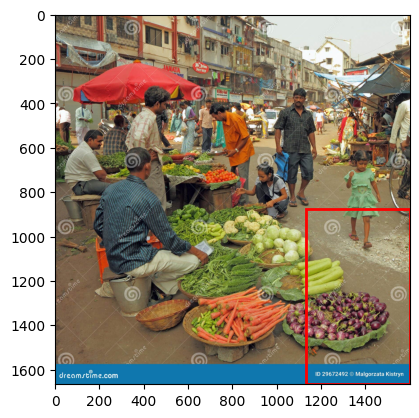

Predicted bbox: [1131, 878, 1599, 1666]


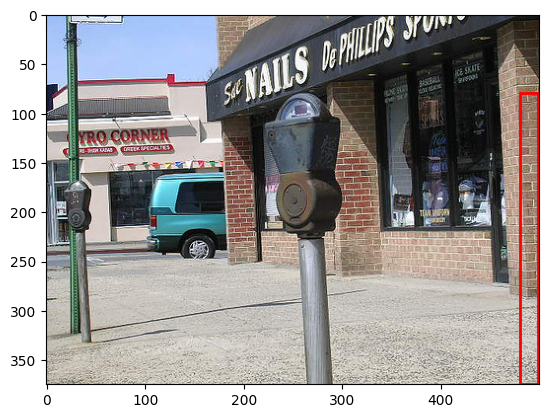

Predicted bbox: [480, 79, 499, 374]


In [24]:
def draw_box(img_path, query):
    model.eval()
    img = Image.open(img_path).convert("RGB")
    w, h = img.size
    img_t = transform(img).unsqueeze(0).to(device)

    tokens = train_dataset.tokenizer(query, return_tensors="pt", padding="max_length",
                                     truncation=True, max_length=32).to(device)

    with torch.no_grad():
        pred_bbox = model(img_t, tokens)[0].cpu().numpy()

    x_min = int(pred_bbox[0]*w)
    y_min = int(pred_bbox[1]*h)
    x_max = int(pred_bbox[2]*w)
    y_max = int(pred_bbox[3]*h)

    fig, ax = plt.subplots(1)
    ax.imshow(img)
    rect = patches.Rectangle((x_min, y_min), x_max-x_min, y_max-y_min,
                             linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.show()
    print("Predicted bbox:", [x_min, y_min, x_max, y_max])

# Example inference
draw_box("street.jpg", "a blue bag")
draw_box("COCO_train2014_000000003148.jpg", "a blue van")

In [ ]:
# =========================================
# 5. Model
# =========================================
class RefBoxModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Image backbone
        self.cnn = models.resnet50(pretrained=True)
        self.cnn.fc = nn.Identity()  # Remove classifier

        # Text encoder
        self.text_model = DistilBertModel.from_pretrained('distilbert-base-uncased')

        # Fusion + bbox regression
        self.fc = nn.Sequential(
            nn.Linear(2048+768, 512),
            nn.ReLU(),
            nn.Linear(512, 4),
            nn.Sigmoid()  # outputs normalized [0,1] bbox
        )

    def forward(self, images, tokens):
        img_feat = self.cnn(images)
        txt_feat = self.text_model(**tokens).last_hidden_state[:,0,:]  # CLS token
        fused = torch.cat([img_feat, txt_feat], dim=1)
        bbox = self.fc(fused)
        return bbox

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = RefBoxModel().to(device)
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)



In [ ]:
# =========================================
# 6. Training Loop
# =========================================
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for imgs, tokens, bboxes in train_loader:
        imgs = imgs.to(device)
        bboxes = bboxes.to(device)
        # Flatten token inputs for GPU
        tokens = {k:v.squeeze(1).to(device) for k,v in tokens.items()}

        optimizer.zero_grad()
        outputs = model(imgs, tokens)
        loss = criterion(outputs, bboxes)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}")



Predicted bbox: [np.float32(1211.5448), np.float32(798.8732), np.float32(1599.7562), np.float32(1666.7898)]


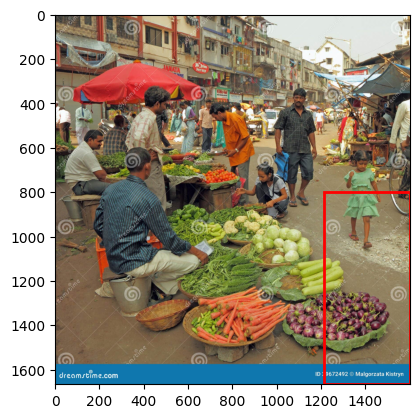

In [10]:
# =========================================
# 7. Inference Example
# =========================================
model.eval()
from torchvision.transforms import ToTensor
test_img_path = "street.jpg"
img = Image.open(test_img_path).convert("RGB")
img_t = transform(img).unsqueeze(0).to(device)

query = "a red umbrella"
tokens = train_dataset.tokenizer(query, return_tensors="pt", padding="max_length",
                                 truncation=True, max_length=32)
tokens = {k:v.to(device) for k,v in tokens.items()}

with torch.no_grad():
    pred_bbox = model(img_t, tokens)[0].cpu().numpy()
    # Convert normalized bbox to pixel coordinates
    w, h = img.size
    pred_bbox_px = [
        pred_bbox[0]*w,
        pred_bbox[1]*h,
        pred_bbox[2]*w,
        pred_bbox[3]*h
    ]
    print("Predicted bbox:", pred_bbox_px)


x_min = int(pred_bbox[0] * w)
y_min = int(pred_bbox[1] * h)
x_max = int(pred_bbox[2] * w)
y_max = int(pred_bbox[3] * h)
fig, ax = plt.subplots(1)
ax.imshow(img)
rect = patches.Rectangle((x_min, y_min), x_max-x_min, y_max-y_min,
                         linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.show()